# Load library and define class and functions

In [2]:
import pickle
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import backend as K
import tensorflow as tf
from keras.utils.np_utils import to_categorical
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
import sys
sys.path.insert(0, "../")
from acousticFeatures import getAllFeatures
import parselmouth 
import numpy as np
from pydub import AudioSegment
from IPython.display import Audio
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
import pandas as pd
from matplotlib.pyplot import subplots_adjust

def parse_metric(confusion_matrix):
    FP = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)  
    FN = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
    TP = np.diag(confusion_matrix)
    TN = confusion_matrix.sum() - (FP + FN + TP)

    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP) 
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    # Negative predictive value
    NPV = TN/(TN+FN)
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    # False negative rate
    FNR = FN/(TP+FN)
    # False discovery rate
    FDR = FP/(TP+FP)
    # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)
    
    return {'FP': FP, 'FN': FN, 'TP':TP, 'TN':TN, 'TPR': TPR, 'TNR': TNR, 'PPV' : PPV, 'NPV' :NPV, 'FPR': FPR, 'FNR': FNR,
           'FDR': FDR, 'ACC':ACC}


class Input:
    def __init__(self, code=None, excited=None, valance=None, arouse=None):
        # File name
        self.__code = code 
        
        # list of predicted values of all frames(4 seconds) in overall interview.
        # 1 for excited, 0 for non-excited.
        self.__excited = excited 
        
        # List of predcited values of all frames in overall interivew
        # Valance values ranging from 1-5
        self.__valance = valance
        
        # The same as the valance
        self.__arouse = arouse
    
    def get_code(self):
        return self.__code
    
    def get_excited(self):
        return self.__excited
    
    def get_valance(self):
        return self.__valance
    
    def get_arouse(self):
        return self.__arouse
    
class Output:
    def __init__(self, dataFrame=None):
        self.__dataFrame = dataFrame
          
    def get_data_frame(self):
        return self.__dataFrame
        

Using TensorFlow backend.


# Load input, output

 - Interview data is preprocessed in file "preprocess_data_interview_data"**

 - For brief, each interview recording (about 3-5 minutes) is divided into smaller frames (4 seconds with 2 seconds overlap). Then each frame is predicted by **models**, which were trained by "sentence level" database

 - There are 3 trained **models**:
    - Classification model that predicts a frame is excited or not (1/0)
    - Regression model of valance that estimate the valance degree of a frame, which ranging in [1-5]
    - Regression model of arouse that estimate the arouse degree of a frame, which ranging in [1-5]


In [4]:
input = pickle.load(open('processed-data/input-interview-frameLengh4-overlap2.obj', 'rb'))
#output = pickle.load(open('processed-data/output-interview.obj', 'rb')) 
print("Size input: {}".format(len(input)))

Size input: 138


# Analysis

## 1. Relationship between percentage of excited frame and real value of excited in interview data

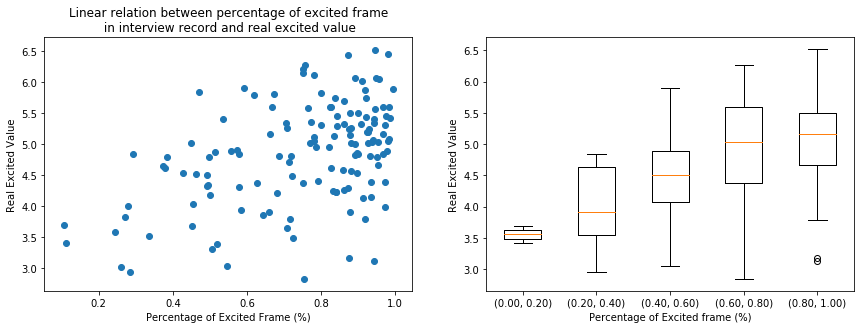

In [8]:
# Percentage of excite frame in interview data
excited = np.array([i.get_excited() for i in input])
percentage_excited_frame = np.array([np.sum(e) / len(e) for e in excited])

# Real Excited values in interview data
df = pd.read_csv("auditary_emotion_recognition/data_interview/Labels/turker_scores_full_interview.csv")
excited_values = []
for k in df.Participant.unique():
    df1 = df.loc[df['Participant'] == k]
    v = df1.iloc[-1]
    excited_values.append(v['Excited'])


# Config
fig, axs = plt.subplots(1,2)
subplots_adjust(right = 2, wspace=0.2, hspace=0.5, bottom=0)

# Scatter
axs[0].scatter(percentage_excited_frame, excited_values) 
axs[0].set_xlabel("Percentage of Excited Frame (%)")
axs[0].set_ylabel("Real Excited Value")
axs[0].set_title("Linear relation between percentage of excited frame\n in interview record and real excited value")

#Boxplot
ls = np.linspace(0,1, 6)
group_ranges = []
for i in range(1, len(ls)):
    group_ranges.append((ls[i-1], ls[i]))

groups_values= []
x_ticklabels = []
for g in group_ranges:
    group = filter(lambda x: g[0]<=x[1] and x[1]<=g[1] , zip(excited_values, percentage_excited_frame))
    exc_value, percent = zip(*group)
    groups_values.append(exc_value)
    x_label = "({}, {})".format(format(g[0], '.2f'), format(g[1], '.2f'))
    x_ticklabels.append(x_label)

axs[1].boxplot(groups_values)
axs[1].set_xticklabels(x_ticklabels)
axs[1].set_xlabel("Percentage of Excited frame (%)")
axs[1].set_ylabel("Real Excited Value")
plt.show();

**Caculate Linear relationship**

In [24]:
from scipy import stats
pearson = stats.pearsonr(percentage_excited_frame, excited_values)
print("Correlation coefficient: {}, P-value: {}".format(pearson[0], pearson[1]))


Correlation coefficient: 0.45646391957384314, P-value: 1.83501231776039e-08


**ROC**

C:\Users\THEDE\Miniconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
C:\Users\THEDE\Miniconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide
C:\Users\THEDE\Miniconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in true_divide


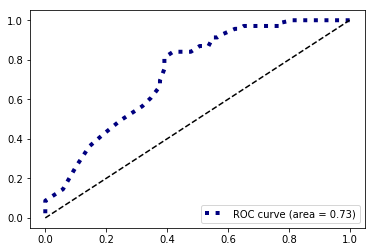

In [9]:
split_point = np.median(excited_values)
y_binary = [ int(e >= split_point) for e in excited_values]

thresholds = np.linspace(0, 1.0, 50)
tpr_arr = []
fpr_arr = []
thresh_arr = [] 
for t in thresholds:
    predict_binary = np.array([int(i >= t) for i in percentage_excited_frame])
    cfm = confusion_matrix(y_binary, predict_binary)
    parse_values = parse_metric(cfm)
    tpr_arr.append(parse_values['TPR'])
    fpr_arr.append(parse_values['FPR'])
    thresh_arr.append(t)
    #print("Threshold:{}, ACC:{}".format(t,parse_values['ACC'][0] ))

fpr_arr = np.asarray(fpr_arr)
tpr_arr = np.asarray(tpr_arr)
roc_auc = auc(fpr_arr[:,1], tpr_arr[:,1])
plt.plot(fpr_arr[:,1], tpr_arr[:,1], label='ROC curve (area = {0:0.2f})'
               ''.format(roc_auc),
         color='navy', linestyle=':', linewidth=4)
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(loc="lower right")
plt.show();

## 2. Relationship between mean arouse of frames and real value of excited in interview data

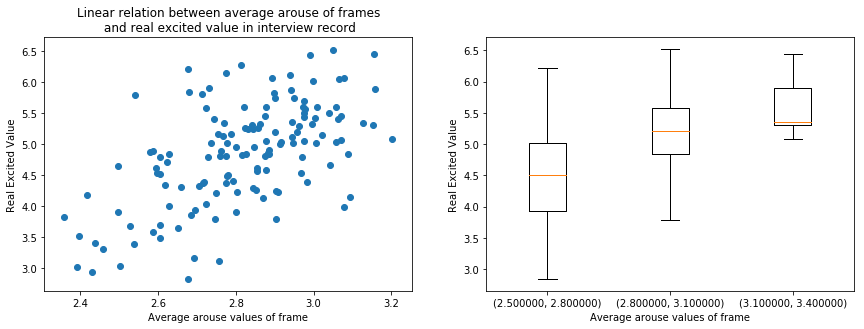

In [15]:
arouse = np.array([i.get_arouse() for i in input])
average_arouse_frame = np.array([np.mean(e)  for e in arouse])

# Excited value of annotators
#df = output.get_data_frame() 
df = pd.read_csv("auditary_emotion_recognition/data_interview/Labels/turker_scores_full_interview.csv")
excited_values = []
for k in df.Participant.unique():
    df1 = df.loc[df['Participant'] == k]
    v = df1.iloc[-1]
    excited_values.append(v['Excited'])


fig, axs = plt.subplots(1,2)
subplots_adjust(right = 2, wspace=0.2, hspace=0.5, bottom=0)
# DrAW scatter
axs[0].scatter(average_arouse_frame, excited_values) 
axs[0].set_xlabel("Average arouse values of frame")
axs[0].set_ylabel("Real Excited Value")
axs[0].set_title("Linear relation between average arouse of frames\n and real excited value in interview record")

#Boxplot
ls = np.linspace(2.5, 3.4, 4)
group_ranges = []
for i in range(1, len(ls)):
    group_ranges.append((ls[i-1], ls[i]))

groups_values= []
x_ticklabels = []
for g in group_ranges:
    group = filter(lambda x: g[0]<=x[1] and x[1]<=g[1] , zip(excited_values, average_arouse_frame))

    exc_value, percent = zip(*group)
    groups_values.append(exc_value)
    x_label = "({}, {})".format(format(g[0], '2f'), format(g[1], '2f'))
    x_ticklabels.append(x_label)

axs[1].boxplot(groups_values)
axs[1].set_xticklabels(x_ticklabels)
axs[1].set_xlabel("Average arouse values of frame")
axs[1].set_ylabel("Real Excited Value")
plt.show();

**Caculate Linear relationship**

In [25]:
from scipy import stats
pearson = stats.pearsonr(average_arouse_frame, excited_values)
print("Correlation coefficient: {}, P-value: {}".format(pearson[0], pearson[1]))


Correlation coefficient: 0.5857068527705813, P-value: 4.4972055892753507e-14


**ROC**

C:\Users\THEDE\Miniconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
C:\Users\THEDE\Miniconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide
C:\Users\THEDE\Miniconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in true_divide


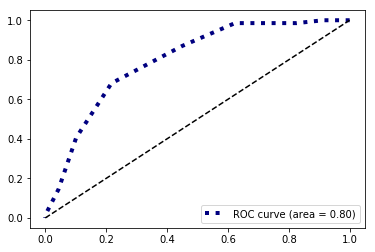

In [11]:
split_point = np.median(excited_values)
y_binary = [ int(e >= split_point) for e in excited_values]

thresholds = np.linspace(0, 5.0, 50)
tpr_arr = []
fpr_arr = []
thresh_arr = [] 
for t in thresholds:
    predict_binary = np.array([int(i >= t) for i in average_arouse_frame])
    cfm = confusion_matrix(y_binary, predict_binary)
    parse_values = parse_metric(cfm)
    tpr_arr.append(parse_values['TPR'])
    fpr_arr.append(parse_values['FPR'])
    thresh_arr.append(t)
    #print("Threshold:{}, ACC:{}".format(t,parse_values['ACC'][0] ))

fpr_arr = np.asarray(fpr_arr)
tpr_arr = np.asarray(tpr_arr)
roc_auc = auc(fpr_arr[:,1], tpr_arr[:,1])
plt.plot(fpr_arr[:,1], tpr_arr[:,1], label='ROC curve (area = {0:0.2f})'
               ''.format(roc_auc),
         color='navy', linestyle=':', linewidth=4)
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(loc="lower right")
plt.show();

## 3. Relationship between mean valance of frames and real value of excited in interview data

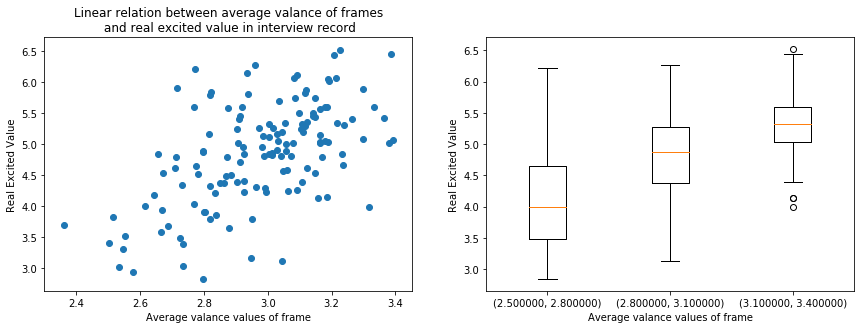

In [16]:
valance = np.array([i.get_valance() for i in input])
average_valance_frame = np.array([np.mean(e)  for e in valance])

# Excited value of annotators
#df = output.get_data_frame() 
df = pd.read_csv("auditary_emotion_recognition/data_interview/Labels/turker_scores_full_interview.csv")
excited_values = []
for k in df.Participant.unique():
    df1 = df.loc[df['Participant'] == k]
    v = df1.iloc[-1]
    excited_values.append(v['Excited'])


fig, axs = plt.subplots(1,2)
subplots_adjust(right = 2, wspace=0.2, hspace=0.5, bottom=0)
# DrAW scatter
axs[0].scatter(average_valance_frame, excited_values) 
axs[0].set_xlabel("Average valance values of frame")
axs[0].set_ylabel("Real Excited Value")
axs[0].set_title("Linear relation between average valance of frames\n and real excited value in interview record")

#Boxplot
ls = np.linspace(2.5, 3.4, 4)
group_ranges = []
for i in range(1, len(ls)):
    group_ranges.append((ls[i-1], ls[i]))

groups_values= []
x_ticklabels = []
for g in group_ranges:
    group = filter(lambda x: g[0]<=x[1] and x[1]<=g[1] , zip(excited_values, average_valance_frame))

    exc_value, percent = zip(*group)
    groups_values.append(exc_value)
    x_label = "({}, {})".format(format(g[0], '2f'), format(g[1], '2f'))
    x_ticklabels.append(x_label)

axs[1].boxplot(groups_values)
axs[1].set_xticklabels(x_ticklabels)
axs[1].set_xlabel("Average valance values of frame")
axs[1].set_ylabel("Real Excited Value")
plt.show();

**Caculate Linear Relationship**

In [27]:
from scipy import stats
pearson = stats.pearsonr(average_valance_frame, excited_values)
print("Correlation coefficient: {}, P-value: {}".format(pearson[0], pearson[1]))


Correlation coefficient: 0.5616250362916456, P-value: 7.710312716690677e-13


**ROC**

C:\Users\THEDE\Miniconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
C:\Users\THEDE\Miniconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide
C:\Users\THEDE\Miniconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in true_divide


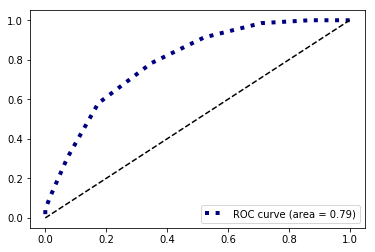

In [17]:
split_point = np.median(excited_values)
y_binary = [ int(e >= split_point) for e in excited_values]

thresholds = np.linspace(0, 5.0, 50)
tpr_arr = []
fpr_arr = []
thresh_arr = [] 
for t in thresholds:
    predict_binary = np.array([int(i >= t) for i in average_valance_frame])
    cfm = confusion_matrix(y_binary, predict_binary)
    parse_values = parse_metric(cfm)
    tpr_arr.append(parse_values['TPR'])
    fpr_arr.append(parse_values['FPR'])
    thresh_arr.append(t)
    #print("Threshold:{}, ACC:{}".format(t,parse_values['ACC'][0] ))

fpr_arr = np.asarray(fpr_arr)
tpr_arr = np.asarray(tpr_arr)
roc_auc = auc(fpr_arr[:,1], tpr_arr[:,1])
plt.plot(fpr_arr[:,1], tpr_arr[:,1], label='ROC curve (area = {0:0.2f})'
               ''.format(roc_auc),
         color='navy', linestyle=':', linewidth=4)
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(loc="lower right")
plt.show();

#  Conclusion
The **mean arouse of frames** (sentence level) have moderate linear relationship with the **overall real excited value** in interview data:
    + Correlation coefficient: 0.58
    + ROC : 0.80